In [1]:
!pip install numpy==1.26.4
!pip install scikit-surprise


Running SVD (PMF approximation)...
SVD (PMF approx) -> mean RMSE: 0.9852, mean MAE: 0.7577
User-KNN (cosine) -> RMSE 0.9934, MAE 0.7672
Item-KNN (cosine) -> RMSE 0.9946, MAE 0.7741
User-KNN (msd) -> RMSE 0.9684, MAE 0.7446
Item-KNN (msd) -> RMSE 0.9352, MAE 0.7214
User-KNN (pearson) -> RMSE 0.9980, MAE 0.7722
Item-KNN (pearson) -> RMSE 0.9900, MAE 0.7688
User-KNN sim=cosine, k=5 -> RMSE 1.0437, MAE 0.8051
User-KNN sim=cosine, k=10 -> RMSE 1.0104, MAE 0.7789
User-KNN sim=cosine, k=20 -> RMSE 0.9964, MAE 0.7682
User-KNN sim=cosine, k=40 -> RMSE 0.9930, MAE 0.7670
User-KNN sim=cosine, k=80 -> RMSE 0.9937, MAE 0.7694
Item-KNN sim=cosine, k=5 -> RMSE 1.1048, MAE 0.8623
Item-KNN sim=cosine, k=10 -> RMSE 1.0496, MAE 0.8197
Item-KNN sim=cosine, k=20 -> RMSE 1.0186, MAE 0.7943
Item-KNN sim=cosine, k=40 -> RMSE 0.9962, MAE 0.7750
Item-KNN sim=cosine, k=80 -> RMSE 0.9817, MAE 0.7631
User-KNN sim=msd, k=5 -> RMSE 0.9853, MAE 0.7532
User-KNN sim=msd, k=10 -> RMSE 0.9634, MAE 0.7372
User-KNN sim=msd

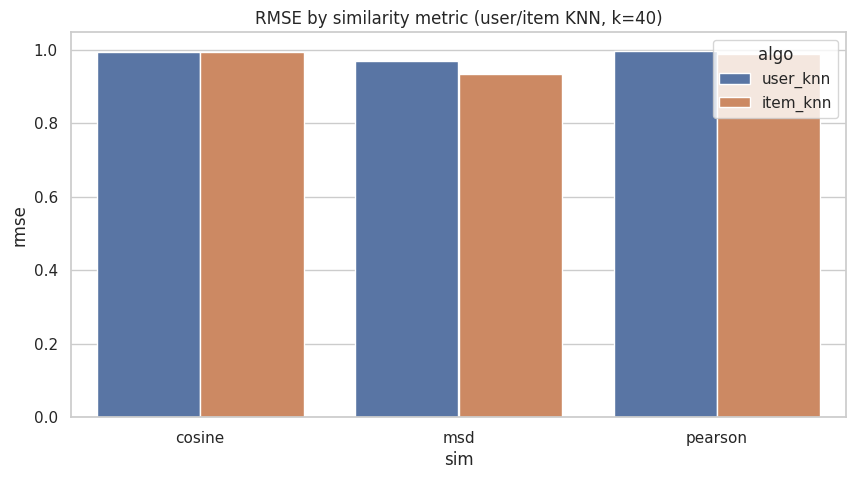

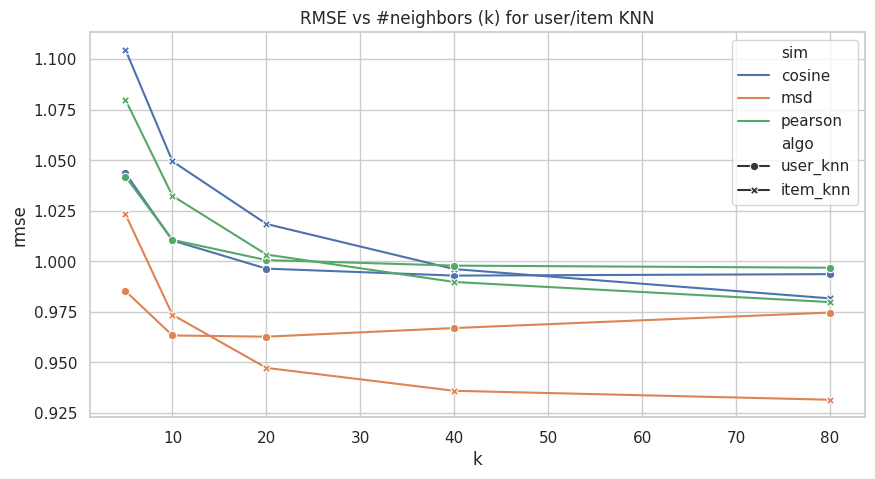

Saved results_similarity_table.csv and results_k_table.csv and plots.


In [2]:
# Task2 - Recommender experiments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import cross_validate, KFold
from surprise import accuracy
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# ---------- Parameters ----------
RATINGS_CSV = "ratings_small.csv" 
RATING_SCALE = (1, 5)
N_FOLDS = 5
RANDOM_STATE = 42

# ---------- Load data ----------
df = pd.read_csv(RATINGS_CSV) 
# drop timestamp if present
if 'timestamp' in df.columns:
    df = df[['userId','movieId','rating']]

reader = Reader(rating_scale=RATING_SCALE)
data = Dataset.load_from_df(df[['userId','movieId','rating']], reader)

# ---------- Utility: cross-validate and return mean MAE/RMSE ----------
def cross_validate_mean(algo, data, measures=['rmse','mae'], cv=N_FOLDS):
    cv_results = cross_validate(algo, data, measures=measures, cv=cv, verbose=False)
    # cross_validate returns test_rmse/test_mae arrays for each fold
    mean_rmse = np.mean(cv_results['test_rmse'])
    mean_mae = np.mean(cv_results['test_mae'])
    return mean_rmse, mean_mae, cv_results

# ---------- 1) PMF (approx with Surprise SVD) ----------
print("Running SVD (PMF approximation)...")
svd = SVD(n_factors=50, biased=False, lr_all=0.005, reg_all=0.02, random_state=RANDOM_STATE)
svd_rmse, svd_mae, svd_cv = cross_validate_mean(svd, data, cv=N_FOLDS)
print(f"SVD (PMF approx) -> mean RMSE: {svd_rmse:.4f}, mean MAE: {svd_mae:.4f}")

# ---------- 2) User-based and Item-based CF baseline (test default sim = cosine / msd / pearson) ----------
sim_metrics = ['cosine', 'msd', 'pearson']
results_sim = []  # collect {algo, sim, rmse, mae}

for sim in sim_metrics:
    # User-based
    sim_options = {'name': sim, 'user_based': True}
    algo_user = KNNBasic(k=40, sim_options=sim_options, verbose=False)
    user_rmse, user_mae, _ = cross_validate_mean(algo_user, data, cv=N_FOLDS)
    results_sim.append({'algo':'user_knn', 'sim':sim, 'rmse':user_rmse, 'mae':user_mae})
    print(f"User-KNN ({sim}) -> RMSE {user_rmse:.4f}, MAE {user_mae:.4f}")

    # Item-based
    sim_options = {'name': sim, 'user_based': False}
    algo_item = KNNBasic(k=40, sim_options=sim_options, verbose=False)
    item_rmse, item_mae, _ = cross_validate_mean(algo_item, data, cv=N_FOLDS)
    results_sim.append({'algo':'item_knn', 'sim':sim, 'rmse':item_rmse, 'mae':item_mae})
    print(f"Item-KNN ({sim}) -> RMSE {item_rmse:.4f}, MAE {item_mae:.4f}")

df_results_sim = pd.DataFrame(results_sim)

# ---------- 3) Neighbor sweep: how number of neighbors k impacts performance ----------
ks = [5, 10, 20, 40, 80] 
results_k = []

# We'll do for each sim metric and for both user-based and item-based
for sim in sim_metrics:
    for algo_type in ['user','item']:
        for k in ks:
            sim_options = {'name': sim, 'user_based': True if algo_type=='user' else False}
            algo = KNNBasic(k=k, sim_options=sim_options, verbose=False)
            rmse, mae, _ = cross_validate_mean(algo, data, cv=N_FOLDS)
            results_k.append({'algo':f'{algo_type}_knn','sim':sim,'k':k,'rmse':rmse,'mae':mae})
            print(f"{algo_type.capitalize()}-KNN sim={sim}, k={k} -> RMSE {rmse:.4f}, MAE {mae:.4f}")

df_results_k = pd.DataFrame(results_k)

# ---------- 4) Compare PMF vs best user/item (choose default k=40 here) ----------
# we already have svd result. find best of user/item from df_results_sim by RMSE
best_user = df_results_sim[(df_results_sim['algo']=='user_knn')].sort_values('rmse').iloc[0]
best_item = df_results_sim[(df_results_sim['algo']=='item_knn')].sort_values('rmse').iloc[0]
print("\nSummary (mean RMSE / MAE):")
print(f"SVD (PMF approx): RMSE={svd_rmse:.4f}, MAE={svd_mae:.4f}")
print(f"Best user-KNN: sim={best_user['sim']}, RMSE={best_user['rmse']:.4f}, MAE={best_user['mae']:.4f}")
print(f"Best item-KNN: sim={best_item['sim']}, RMSE={best_item['rmse']:.4f}, MAE={best_item['mae']:.4f}")

# ---------- 5) Plotting results ----------
plt.figure(figsize=(10,5))
sns.barplot(data=df_results_sim, x='sim', y='rmse', hue='algo')
plt.title('RMSE by similarity metric (user/item KNN, k=40)')
plt.savefig('rmse_by_similarity.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(data=df_results_k, x='k', y='rmse', hue='sim', style='algo', markers=True, dashes=False)
plt.title('RMSE vs #neighbors (k) for user/item KNN')
plt.savefig('rmse_vs_k.png', bbox_inches='tight')
plt.show()

# Save result tables for assignment
df_results_sim.to_csv("results_similarity_table.csv", index=False)
df_results_k.to_csv("results_k_table.csv", index=False)

print("Saved results_similarity_table.csv and results_k_table.csv and plots.")
